# Examples from docs

source: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

# Introduction

## Graph data container

In [1]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)

x = torch.tensor([-1, 0, 1], dtype=torch.float).unsqueeze(1)
data = Data(x=x, edge_index=edge_index)
data

Data(x=[3, 1], edge_index=[2, 4])

In [2]:
print(data['x'],'\n', data['edge_index'])

tensor([[-1.],
        [ 0.],
        [ 1.]]) 
 tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


In [3]:
print(f'number of nodes: {data.num_nodes}\nnumber of edges: {data.num_edges}\nnumber of node features: {data.num_edge_features}\nisolated nodes: {data.has_isolated_nodes()}')

number of nodes: 3
number of edges: 4
number of node features: 0
isolated nodes: False


In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(DEVICE) # can store graph at GPU if needed

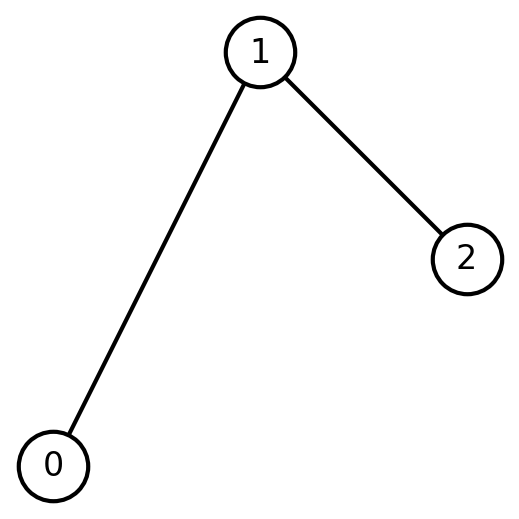

In [5]:
# Преобразование в формат для отображения
# Галерея кастомных выводов: https://networkx.org/documentation/stable/auto_examples/index.html
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx


G = to_networkx(data=data, to_undirected=True)

pos = {
    0: (0, 0),
    1: (0.5, 0.5),
    2: (1, 0.25)
}

options = {
    "font_size": 24,
    "node_size": 2500,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 3,
    "width": 3,
    "with_labels": True,
}

plt.figure(figsize=(5, 5))
nx.draw(G, pos,**options)

## Playable datasetes provided by pytorch_geometric

In [6]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='./data/ENZYMES', name='ENZYMES')
len(dataset)

Extracting data\ENZYMES\ENZYMES\ENZYMES.zip
Processing...
Done!


600

In [7]:
print(dataset.num_classes, dataset.num_node_features)

6 3


Data(edge_index=[2, 168], x=[37, 3], y=[1])


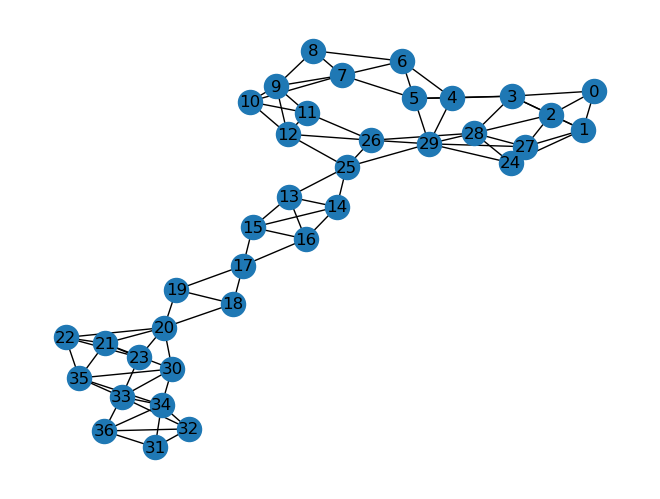

In [8]:
print(dataset[0])
nx.draw_kamada_kawai(to_networkx(dataset[0], to_undirected=True), with_labels=True)

In [9]:
# perform train/test split with shuffling
# dataset = dataset.shuffle() # same as dataset[torch.randomperm(len(dataset))]
tr_size = int(len(dataset)*0.9)
train_dataset, test_dataset = dataset[:tr_size], dataset[tr_size:]
print(train_dataset, test_dataset)

ENZYMES(540) ENZYMES(60)


## Mini-batches over graphs

In [15]:
# Batches functionality is provided by Loaders (just like in torch)
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

single_batch = next(iter(train_loader))
print(single_batch) # merged objects from dataset
print(single_batch[0]) # actual Data object

DataBatch(edge_index=[2, 4134], x=[1074, 3], y=[32], batch=[1074], ptr=[33])
Data(edge_index=[2, 78], x=[23, 3], y=[1])


## Data transforms

In [ ]:
# transform - for transformation befor accessing
# pre_transform - for transformation before saving to disk

from torch_geometric.datasets import ShapeNet

dataset = ShapeNet(root='data/ShapeNet', categories=['Airplane'])
dataset[0]

In [ ]:
# We can generate graphs from cloud of points by using nearest neighbours approach
import torch_geometric.transforms as T

dataset = ShapeNet(
    root='data/ShapeNetTransformed', 
    categories=['Airplane'], 
    pre_transform=T.KNNGraph(k=6), # this transforms will be applied before and this how dataset will be stored at disk
    transform=T.RandomJitter(1e-2))
dataset[0]

## Train your first model (GCN)

In [17]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='data/Cora', name='Cora')
dataset

Processing...
Done!


Cora()

In [18]:
dataset[0] # data is all set up

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

### Model

In [24]:
import torch 
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


### Training

In [27]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(DEVICE)
data = dataset[0].to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)

model.train()
loss_hist = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())

Text(0, 0.5, 'cross-entropy loss')

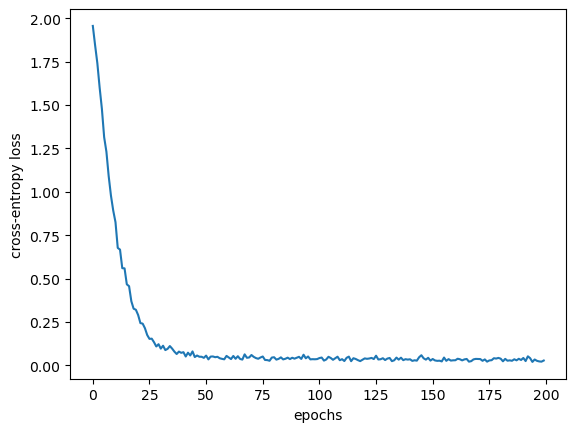

In [28]:
import matplotlib.pyplot as plt

plt.plot(loss_hist)
plt.xlabel('epochs')
plt.ylabel('cross-entropy loss')

## Evaluation

In [29]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = correct / data.test_mask.sum()
print(f"Accuracy on test: {acc:.4f}")

Accuracy on test: 0.7930


# Creating MPN (Message Passing Network)

Formal generalization of convolution operator looks like this:

$x^{(k)}_i = \gamma^{(k)}(x^{(k - 1)}_i, AGG_{j \in N_{(i)}}\phi^{k}(x^{(k - 1)}_i, x^{(k-1)}_i, x^{(k-1)}_j, e_{j, i}))$

where $\gamma$ and $\phi$ are some differentiable functions (like MLP), $AGG$ is a differentiable and permutation invariant function (mean, max, min)

For creating custom MPN there is a base ```MessagePassing``` class, that takes care of message passing. You only need to define functions $\phi$ and $\gamma$

GCN layer is a thing that goes like

$x^{(k)}_i = \sum_{j \in N{(i)} \cup \{i\}} \frac{1}{\sqrt{deg(i)} \cdot \sqrt{deg(j)}} \cdot (W^T \cdot x^{(k - 1)}_j) + b$

This formula can be divided in following steps:
1. Add self-loops to the adj matrix
2. Linearly transform node feature matrix
3. Compute norm coeffs
4. Normalize node features
5. Sum up neighbour features
6. Add bias

Note about ```message()``` method and it's magic:

![](imgs/doc_screen_1.png)

## Implement simple GCN

In [30]:
import torch

from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add') # specify AGG beforehand (step 5)
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.tensor(out_channels))

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()
    
    def forward(self, x, edge_index):
        # add self-loops to adj matrix
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        # apply linear transformation
        x = self.lin(x)
        # compute norm
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0 # case where nodes has 0 degree
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        # prop messages
        out = self.propagate(edge_index, x=x, norm=norm) # internally calles message(), aggregate() and update()
        # apply bias
        out += self.bias
        return out

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

## Implement Edge Conv Layer
paper: https://arxiv.org/abs/1801.07829

for reference:

$x^{(k)}_i = \max_{j \in N(i)} h_\theta (x^{(k - 1)}_i, x^{(k - 1)}_j - x^{(k - 1)}_i)$

where $h_\theta$ is MLP

In [31]:
import torch
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing

class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='max') # max aggregation
        self.mlp = Sequential(
            Linear(2*in_channels, out_channels),
            ReLU(),
            Linear(out_channels, out_channels)
        )

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j - x_i], dim=1)
        return self.mlp(tmp)

In [32]:
# GPU accelerated batch wise knn graph generation over dynamic edge changes in graph
from torch_geometric.nn import knn_graph

class DynamicEdgeConv(EdgeConv):
    def __init__(self, in_channels, out_channels, k=6):
        super().__init__(in_channels, out_channels)
        self.k = k

    def forward(self, x, batch=None):
        edge_index = knn_graph(x, self.k, batch, loop=False, flow=self.flow)
        return super().forward(x, edge_index)

# Creating your Datasets

Two base classes: ```torch_geometric.data.Dataset``` and ```torch_geometric.data.InMemoryDataset```, which should be used when whole dataset fits into memory

By convention of torch_geometric, root_folder gets split into subfolders: raw_dir and processed_dir. Datasets also accepts transform, pre_transform and pre_filter.

## Example of InMemoryDataset

![](imgs/doc_screen_2.png)

In [ ]:
import torch
from torch_geometric.data import InMemoryDataset, download_url


class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2', ...]

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        # Download to `self.raw_dir`.
        download_url(url, self.raw_dir)
        ...

    def process(self):
        # Read data into huge `Data` list.
        data_list = [...]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

## Example of Dataset

In [ ]:
import os.path as osp

import torch
from torch_geometric.data import Dataset, download_url


class MyOwnDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2', ...]

    @property
    def processed_file_names(self):
        return ['data_1.pt', 'data_2.pt', ...]

    def download(self):
        # Download to `self.raw_dir`.
        path = download_url(url, self.raw_dir)
        ...

    def process(self):
        idx = 0
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.
            data = Data(...)

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data